In [72]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
from pprint import pprint
from collections import namedtuple

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams["image.origin"] = 'lower'

fillinfo = namedtuple("fillinfo", ["fill", "beamstatus", "lumi_inst", "lumi_in_fill", "time_in_fill", "time_in_fill_stable"])

In [ ]:
data_EE = np.load("transp_data_EE.npy")
data_EB = np.load("transp_data_EB.npy")

In [2]:
meta = pd.read_csv("transp_metadata_2017.csv",sep=",").astype({"transp_entry":"int64", "time": "int64", "fill_num":"int64", "time_in_fill":"int64", "time_in_fill_stable":"int64"})
bril = pd.read_csv("lumi_brilcalc_2017.csv", sep=",", comment="#")
bril["run"] = bril.apply(lambda row: int(row["run:fill"].split(":")[0]), axis=1)
bril["fill"] = bril.apply(lambda row: int(row["run:fill"].split(":")[1]), axis=1)

In [3]:
print(meta.columns)
print(bril.columns)

Index(['transp_entry', 'time', 'bfield', 'fill_num', 'fill_time_start',
       'fill_time_stable_start', 'time_in_fill', 'time_in_fill_stable',
       'run_in_fill', 'in_fill'],
      dtype='object')
Index(['run:fill', 'ls', 'time', 'beamstatus', 'E(GeV)', 'delivered(/ub)',
       'recorded(/ub)', 'avgpu', 'source', 'run', 'fill'],
      dtype='object')


## Starting lumisection

In [180]:
def gettimes(timestamp, n, t=23):
    o = []
    for i in range(abs(n)):
            o.append(timestamp + i*t)
    if n >0:
        return o
    else:
        o.reverse()
        return o


Look for the biggest deltaT between measurements

In [382]:
meta["time-1"] = meta["time"].shift(1)
meta["deltaT"] = (meta["time"]- meta["time-1"])

Cumulative luminosity over fill

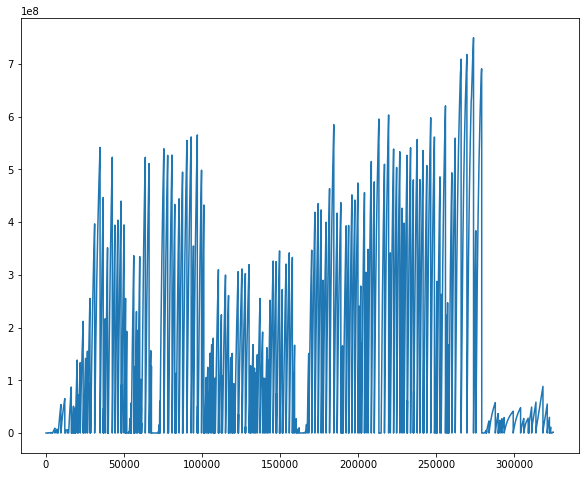

In [7]:
plt.plot(bril.groupby("fill")["delivered(/ub)"].cumsum())

## Cumulative lumi in fill estimation

In [125]:
bril["lumi_in_fill"] = bril.groupby("fill")["delivered(/ub)"].cumsum()
bril["time_in_fill"] = bril.groupby("fill")["time"].transform(lambda t: t - t.min())
bril["time_in_fill_stable"] = bril[bril.beamstatus=="STABLE BEAMS"].groupby("fill")["time"].transform(lambda t: t - t.min())
bril["time_in_fill_stable"] = bril["time_in_fill_stable"].fillna(0)

## Fill start time saving

In [111]:
def is_in_fill(timestamp):
    a = bril[abs(bril.time - timestamp)<23]
    if len(a):
        a = a.iloc[0]
        return fillinfo(a.fill, a.beamstatus, a["delivered(/ub)"], a.lumi_in_fill, a.time_in_fill, a.time_in_fill_stable)
    else:
        return fillinfo(0, "NOBEAM", 0, 0,0,0)
    
#is_in_fill(starting_time)

In [112]:
def get_lumi_interval(timestart, timestop):
    return bril[ (bril.time >= timestart) & (bril.time <= timestop)]["delivered(/ub)"].sum()

#get_lumi_interval(starting_time, 1512022951 )

In [113]:
def get_last_fill_end(timestamp, fill=0):
    df = bril[(bril.time <=timestamp) & (bril.fill != fill)]
    if not df.empty:
        return df.iloc[-1]
    else: 
        return pd.DataFrame()

In [114]:
def get_fill_timeinterval(fill):
    t = bril[bril.fill== fill].time
    return t.iloc[0], t.iloc[-1]

In [86]:
get_last_fill_end_totlumi(1495587035)

(1495575925, 300020.918324365)

In [87]:
get_fill_timeinterval(6417)

(1511659746, 1511692258)

In [191]:
outputs = {
    "in_fill" : [],
    "time": [],
    "lumi_inst": [],
    "lumi_in_fill": [],
    "lumi_since_last_point": [],
    "lumi_last_fill": [],
    "fill_num": [],
    "time_in_fill": [],
    "time_in_fill_stable": [],
    "time_from_last_fill" : [],
    "last_dump_duration" : [],
    "last_fill_duration": [],
}


def add_output(out):
    for k, v in out.items():
        outputs[k].append(v)


In [192]:
previous_time = bril.time.iloc[0]
tot = (bril.time.iloc[-1]-bril.time.iloc[0])//900

for iev, curr_time in enumerate(range(bril.time.iloc[0], bril.time.iloc[-1], 900)):
    if iev % 100 == 0:
        print(f"{iev}/{tot}")
    
    fill_info = is_in_fill(curr_time)
    
    last_fill_info = get_last_fill_end(curr_time, fill_info.fill)
    
    if last_fill_info.empty:
        last_fill_end = curr_time
        last_fill_duration = 0
        last_dump_duration = 0
        lumi_last_fill = 0
    else:
        last_fill_end = last_fill_info.time
        last_fill_duration = last_fill_info.time_in_fill
        lumi_last_fill = last_fill_info.lumi_in_fill
        
        if fill_info.fill != 0:
            last_dump_duration =  (curr_time - fill_info.time_in_fill) - last_fill_info.time 
        else:
            last_dump_duration = curr_time - last_fill_info.time 
    
    time_from_last_fill = curr_time - last_fill_end
    lumi_since_last_point = get_lumi_interval(previous_time,curr_time)
    
    out = {
        "in_fill": int(fill_info.fill != 0),
        "time": curr_time,
        "fill_num": fill_info.fill,
        "lumi_inst": fill_info.lumi_inst,
        "lumi_in_fill": fill_info.lumi_in_fill,
        "lumi_since_last_point": lumi_since_last_point,
        "lumi_last_fill": lumi_last_fill,
        
        "time_in_fill": fill_info.time_in_fill,
        "time_in_fill_stable":  fill_info.time_in_fill_stable,
        "time_from_last_fill": time_from_last_fill, 
        "last_dump_duration": last_dump_duration, 
        "last_fill_duration": last_fill_duration
    }
    
    previous_time = curr_time
    add_output(out)



0/18312
100/18312
200/18312
300/18312
400/18312
500/18312
600/18312
700/18312
800/18312
900/18312
1000/18312
1100/18312
1200/18312
1300/18312
1400/18312
1500/18312
1600/18312
1700/18312
1800/18312
1900/18312
2000/18312
2100/18312
2200/18312
2300/18312
2400/18312
2500/18312
2600/18312
2700/18312
2800/18312
2900/18312
3000/18312
3100/18312
3200/18312
3300/18312
3400/18312
3500/18312
3600/18312
3700/18312
3800/18312
3900/18312
4000/18312
4100/18312
4200/18312
4300/18312
4400/18312
4500/18312
4600/18312
4700/18312
4800/18312
4900/18312
5000/18312
5100/18312
5200/18312
5300/18312
5400/18312
5500/18312
5600/18312
5700/18312
5800/18312
5900/18312
6000/18312
6100/18312
6200/18312
6300/18312
6400/18312
6500/18312
6600/18312
6700/18312
6800/18312
6900/18312
7000/18312
7100/18312
7200/18312
7300/18312
7400/18312
7500/18312
7600/18312
7700/18312
7800/18312
7900/18312
8000/18312
8100/18312
8200/18312
8300/18312
8400/18312
8500/18312
8600/18312
8700/18312
8800/18312
8900/18312
9000/18312
9100/18312


In [193]:
output_df = pd.DataFrame(outputs)

In [195]:
bril[bril.fill==5697]

,run:fill,ls,time,beamstatus,E(GeV),delivered(/ub),recorded(/ub),avgpu,source,run,fill,lumi_in_fill,time_in_fill,time_in_fill_stable
0,294904:5697,57:0,1495541393,FLAT TOP,6500,0.125840,0.0,0.0,PLTZERO,294904,5697,0.125840,0,0.0
1,294904:5697,58:0,1495541413,FLAT TOP,6500,0.126789,0.0,0.5,PLTZERO,294904,5697,0.252629,20,0.0
2,294904:5697,59:0,1495541436,FLAT TOP,6500,0.122161,0.0,0.5,PLTZERO,294904,5697,0.374790,43,0.0
3,294904:5697,60:0,1495541460,FLAT TOP,6500,0.118824,0.0,0.7,PLTZERO,294904,5697,0.493614,67,0.0


In [194]:
output_df

,in_fill,time,lumi_inst,lumi_in_fill,lumi_since_last_point,lumi_last_fill,fill_num,time_in_fill,time_in_fill_stable,time_from_last_fill,last_dump_duration,last_fill_duration
0,1,1495541393,0.125840,1.258399e-01,0.125840,0.000000,5697,0,0.0,0,0,0
1,0,1495542293,0.000000,0.000000e+00,0.493614,0.493614,0,0,0.0,833,833,67
2,0,1495543193,0.000000,0.000000e+00,0.000000,0.493614,0,0,0.0,1733,1733,67
3,0,1495544093,0.000000,0.000000e+00,0.000000,0.493614,0,0,0.0,2633,2633,67
4,0,1495544993,0.000000,0.000000e+00,0.000000,0.493614,0,0,0.0,3533,3533,67
5,0,1495545893,0.000000,0.000000e+00,0.000000,0.493614,0,0,0.0,4433,4433,67
6,0,1495546793,0.000000,0.000000e+00,0.000000,0.493614,0,0,0.0,5333,5333,67
7,0,1495547693,0.000000,0.000000e+00,0.000000,0.493614,0,0,0.0,6233,6233,67
8,1,1495548593,0.121032,2.593413e-01,0.259341,0.493614,5698,23,0.0,7133,7110,67
9,1,1495549493,0.132810,5.131346e+00,4.872005,0.493614,5698,922,0.0,8033,7111,67
